In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np
from scipy.stats import uniform as sp_rand
from scipy.stats import randint as sp_randint
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt
import pickle

## 6. Model

In [2]:
# data
dt_model = pd.read_csv("../../data/Mercedes_Benz_Greener_Manufacturing/data/dt_all_eng.csv")
# IDs
IDs_train = pickle.load(open("../../data/Mercedes_Benz_Greener_Manufacturing/data/IDs_train.pkl", "rb"))
IDs_test = pickle.load(open("../../data/Mercedes_Benz_Greener_Manufacturing/data/IDs_test.pkl", "rb"))
# cols
cols_cat = pickle.load(open("../../data/Mercedes_Benz_Greener_Manufacturing/data/cols_cat.pkl", "rb"))

In [3]:
# r_2 for xgboost
def r_2(preds, dtrain):
    labels = dtrain.get_label()
    return 'score', r2_score(labels, preds)

In [4]:
# remove ohe
dt_model_features = dt_model.drop(dt_model.filter(regex = "Encode_ohe").columns, axis = 1)
dt_model_features.shape

(8418, 1361)

In [5]:
# X, y, ID
X_train_all = dt_model_features.loc[dt_model_features["ID"].isin(IDs_train)].drop(["y"] + list(cols_cat), axis = 1)
X_test = dt_model_features.loc[dt_model_features["ID"].isin(IDs_test)].drop(["y"] + list(cols_cat), axis = 1)
y_train_all = dt_model_features.loc[dt_model_features["ID"].isin(IDs_train)].y.values
y_test = dt_model_features.loc[dt_model_features["ID"].isin(IDs_test)].y.values

In [21]:
ID_test = dt_model_features.loc[dt_model_features["ID"].isin(IDs_test)].ID.values

In [6]:
X_train_all.shape

(4209, 1352)

### 6.1 xgboost

In [7]:
params_xgb = {
    'n_trees': 5000,
    'eta': 0.005,
    'max_depth': 2,
    'min_child_weight': 0,
    'subsample': 0.95,
    'objective': 'reg:linear',
    'booster': 'gbtree',
    'eval_metric': 'rmse',
    'base_score': np.mean(y_train_all), # base prediction = mean(target)
    'silent': 1,
}

In [8]:
# xgbDmatrix
dtrain = xgb.DMatrix(X_train_all, y_train_all)
dtest = xgb.DMatrix(X_test)

In [9]:
# cv
cv_xgb = xgb.cv(params_xgb, dtrain
                , num_boost_round = 5000
                , nfold = 10
                , feval = r_2, maximize = True, early_stopping_rounds = 50
                , show_stdv = True, verbose_eval = 50, seed = 888)

[0]	train-rmse:12.6487+0.121207	train-score:0.005611+0.000111734	test-rmse:12.608+1.02225	test-score:0.0029683+0.00354666
[50]	train-rmse:11.1623+0.12935	train-score:0.225623+0.00384626	test-rmse:11.1106+1.10307	test-score:0.227443+0.0292599
[100]	train-rmse:10.1547+0.138279	train-score:0.359128+0.00613471	test-rmse:10.1081+1.16779	test-score:0.361404+0.04566
[150]	train-rmse:9.47563+0.141356	train-score:0.441974+0.00704298	test-rmse:9.47684+1.21313	test-score:0.438973+0.054907
[200]	train-rmse:9.0183+0.138411	train-score:0.494535+0.00709029	test-rmse:9.06787+1.24988	test-score:0.486397+0.0611032
[250]	train-rmse:8.71046+0.131967	train-score:0.52845+0.00675239	test-rmse:8.80422+1.27742	test-score:0.515752+0.0653102
[300]	train-rmse:8.49754+0.124275	train-score:0.551215+0.00636949	test-rmse:8.63292+1.29654	test-score:0.534301+0.0680715
[350]	train-rmse:8.34413+0.116842	train-score:0.567266+0.00606469	test-rmse:8.52486+1.30394	test-score:0.545775+0.0694068
[400]	train-rmse:8.2269+0.11009

In [10]:
# train
model_xgb = xgb.train(params_xgb, dtrain, num_boost_round = cv_xgb.shape[0])

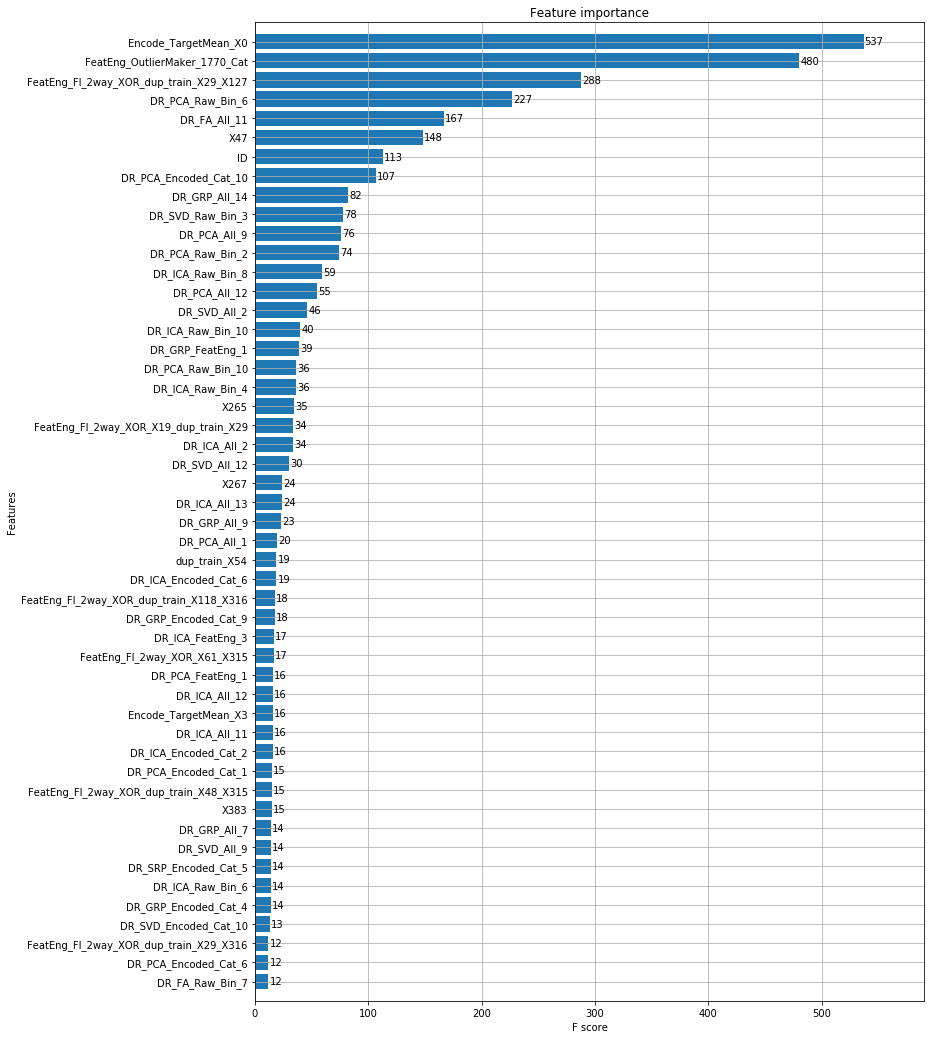

In [11]:
# importance
fig, ax = plt.subplots(figsize = (12,18))
xgb.plot_importance(model_xgb, max_num_features = 50, height = 0.8, ax = ax)
plt.show()

In [12]:
# predict
y_test = model_xgb.predict(dtest)
y_test[:10]

array([  92.2029953 ,   94.13188934,   94.48922729,  110.84929657,
        110.19005585,   94.89775085,   94.89775085,   92.90144348,
         94.65591431,   93.69503021], dtype=float32)

In [22]:
# submit
dt_submit = pd.DataFrame({"ID": ID_test, "y": y_test})
dt_submit.head()

,ID,y
0,2849,92.202995
1,2710,94.131889
2,4077,94.489227
3,7454,110.849297
4,7484,110.190056


In [23]:
dt_submit.shape

(4209, 2)

In [24]:
dt_submit.to_csv("../../data/Mercedes_Benz_Greener_Manufacturing/submission/19_cleaned_python.csv", index = False)